In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F

from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
from keychest.keychestenv import keychest_obs3d_to_obs2d, keychest_obs2d_to_image
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
import pickle as pickle
from causal_util.helpers import one_hot_encode
import gin
from keychest.features_xy import obs_features_handcoded, arr_to_dict, dict_to_arr
import io

In [8]:
import ray
ray.init()

2021-01-26 13:42:06,869	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.26.78.149',
 'raylet_ip_address': '172.26.78.149',
 'redis_address': '172.26.78.149:6379',
 'object_store_address': '/tmp/ray/session_2021-01-26_13-42-05_916346_10253/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-26_13-42-05_916346_10253/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-26_13-42-05_916346_10253',
 'metrics_export_port': 56118,
 'node_id': '9b4c4a03ef09bbddf7176520ed2dc04945b2d524'}

In [5]:
ckpt = '/home/sergei/ray_results/ve5_rec_nonlin_gnn_gumbel_siamese_l2_ve5_dec_rec/main_fcn_2671b_00000_0_2021-01-26_08-36-06/checkpoint_3000/checkpoint'

In [6]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [9]:
with open(ckpt, 'rb') as f:
    learner = CPU_Unpickler(f).load()#pickle.load(f)

2021-01-26 13:42:18,476	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name ed0e6e3e-5fd3-11eb-b10c-cdb71eed431e
Make environment VectorIncrement-v0 None {}


(array([ 2., 16., 35., 51., 68., 54., 48., 27., 18.,  4.]),
 array([-2.0155616, -1.864779 , -1.7139965, -1.563214 , -1.4124314,
        -1.2616489, -1.1108663, -0.9600837, -0.8093012, -0.6585186,
        -0.5077361], dtype=float32),
 <BarContainer object of 10 artists>)

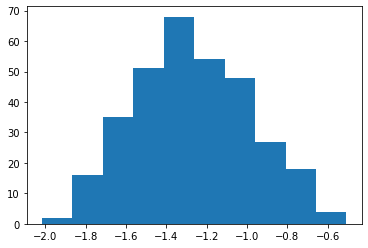

In [16]:
plt.hist(np.log10(learner.model.Mf.flatten()))

(array([ 6., 15., 18., 19., 14., 13.,  2.,  3.,  0.,  5.]),
 array([-1.9253919 , -1.7836089 , -1.641826  , -1.5000432 , -1.3582602 ,
        -1.2164772 , -1.0746943 , -0.93291134, -0.7911284 , -0.64934546,
        -0.5075625 ], dtype=float32),
 <BarContainer object of 10 artists>)

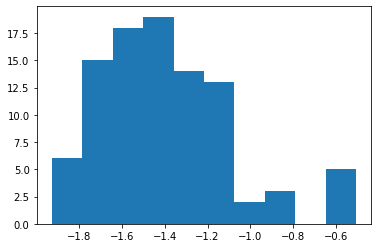

In [17]:
plt.hist(np.log10(learner.model.Ma.flatten()))

In [21]:
sw = learner.model.model_fout_0000.switch

In [22]:
sw.shape

(22,)

In [41]:
sampled = [sw(torch.ones((1, 22)))[0].detach().numpy() for _ in range(1000)]

In [123]:
np.array(sampled).mean(0)

array([0.121, 0.027, 0.058, 0.067, 0.137, 0.032, 0.044, 0.081, 0.075,
       0.062, 0.07 , 0.035, 0.021, 0.044, 0.014, 0.041, 0.049, 0.059,
       0.012, 0.029, 0.072, 0.043], dtype=float32)

In [124]:
torch.nn.functional.gumbel_softmax(sw.logits, tau=1, hard=True, dim=0)[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], grad_fn=<SelectBackward>)

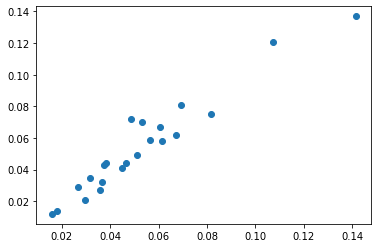

In [129]:
plt.scatter(sw.softmaxed().detach().numpy(), np.array(sampled).mean(0))